In [22]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING'

## Computational considerations

As we will see, FWI is computationally extremely demanding, even more than RTM. To keep this tutorial as lightwight as possible we therefore again use a very small demonstration model. We also define here a few parameters for the final example runs that can be changed to modify the overall runtime of the tutorial.

In [23]:
nshots = 9  # Number of shots to create gradient from
nreceivers = 101  # Number of receiver locations per shot 
fwi_iterations = 5  # Number of outer FWI iterations

In [7]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING'

Operator `initdamp` ran in 0.01 s
Operator `initdamp` ran in 0.01 s


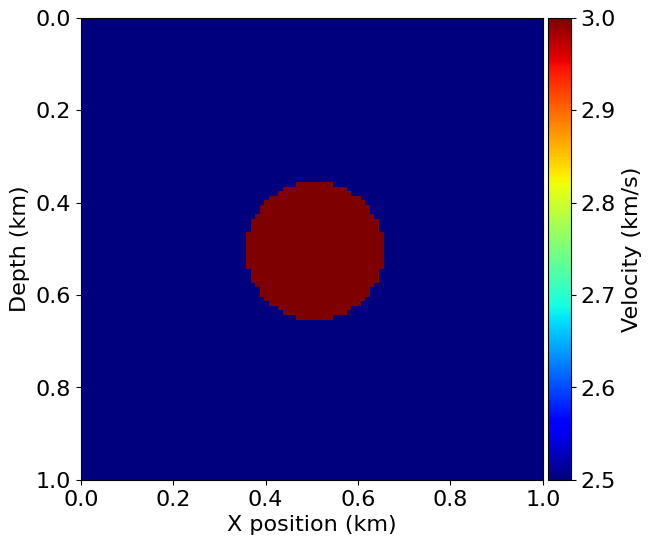

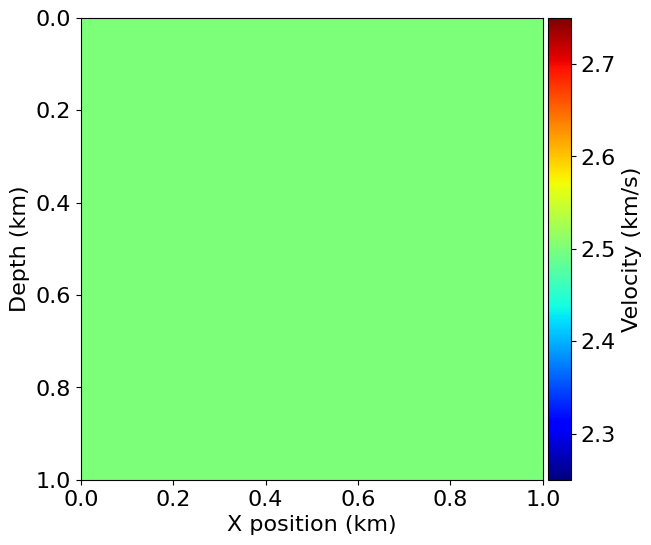

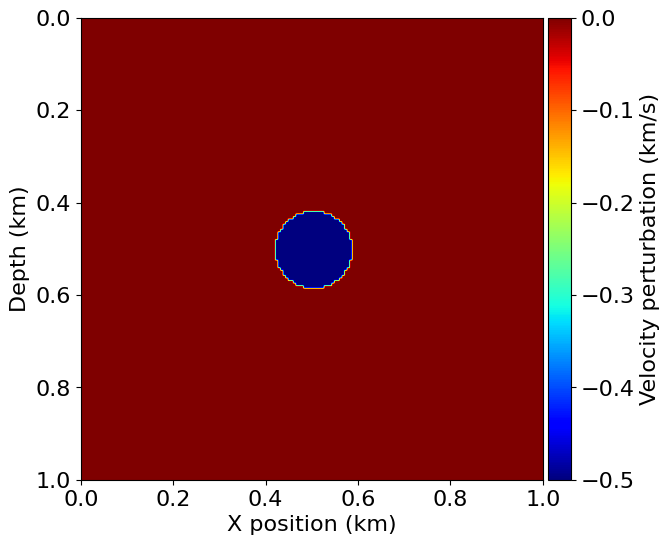

In [4]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import demo_model, plot_velocity, plot_perturbation

# Define true and initial model
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations

model = demo_model('circle-isotropic', vp_circle=3.0, vp_background=2.5,
                    origin=origin, shape=shape, spacing=spacing, nbl=40)

model0 = demo_model('circle-isotropic', vp_circle=2.5, vp_background=2.5,
                     origin=origin, shape=shape, spacing=spacing, nbl=40,
                     grid = model.grid)

plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

In [5]:
nshots = 9  # Number of shots to create gradient from
nreceivers = 101  # Number of receiver locations per shot 
fwi_iterations = 5  # Number of outer FWI iterations

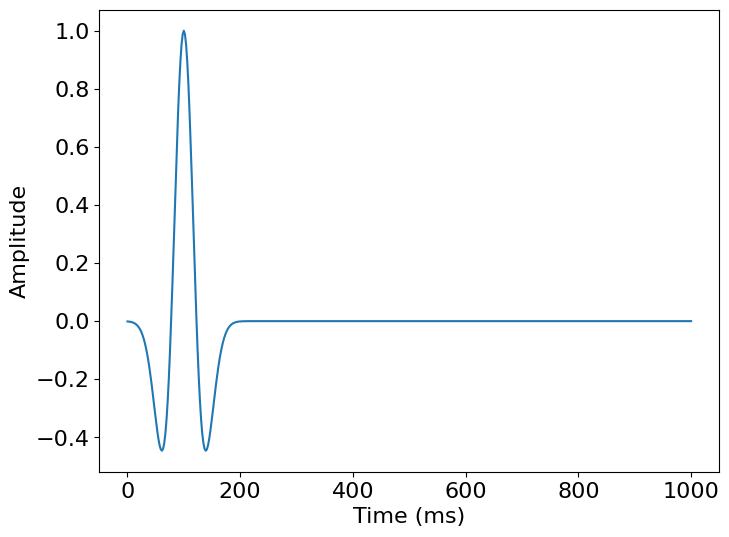

In [8]:
#NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry

t0 = 0.
tn = 1000. 
f0 = 0.010
# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, 0] = 20.  # Depth is 20m


# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 1] = np.linspace(0, model.domain_size[0], num=nreceivers)

rec_coordinates[:, 0] = 980.

# Geometry

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()

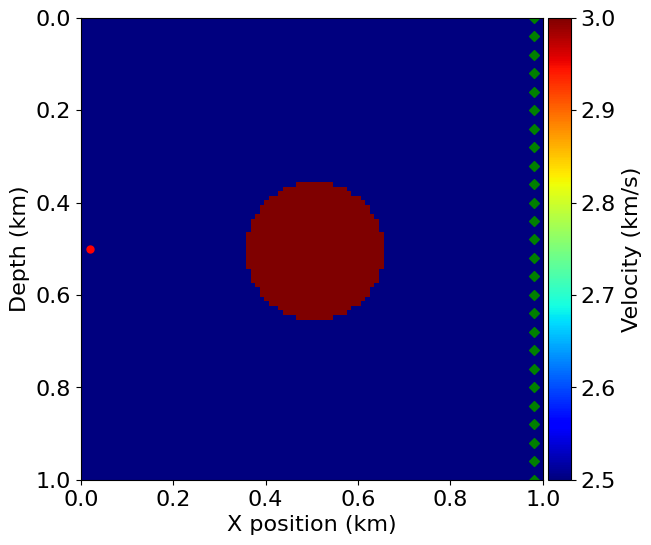

In [9]:
#NBVAL_IGNORE_OUTPUT
# Plot acquisition geometry
plot_velocity(model, source=geometry.src_positions,
              receiver=geometry.rec_positions[::4, :])

In [10]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, geometry, space_order=4)
true_d, _, _ = solver.forward(vp=model.vp)

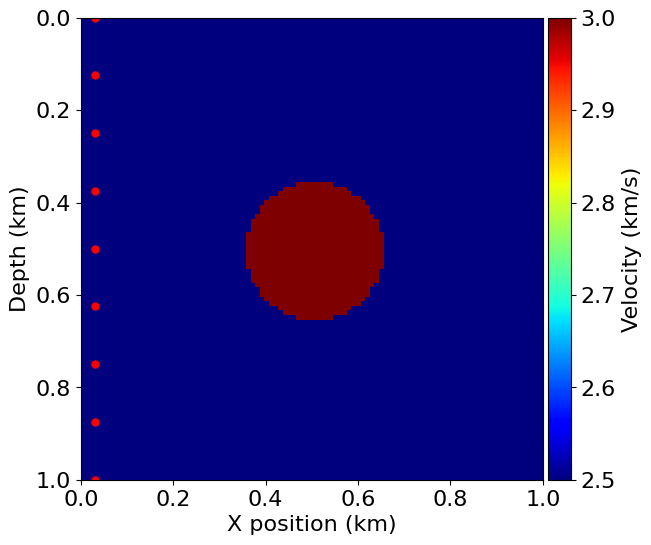

In [11]:
#NBVAL_IGNORE_OUTPUT

# Prepare the varying source locations sources
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = 30.
source_locations[:, 1] = np.linspace(0., 1000, num=nshots)

plot_velocity(model, source=source_locations)

In [12]:
from devito import Eq, Operator

# Computes the residual between observed and synthetic data into the residual
def compute_residual(residual, dobs, dsyn):
    if residual.grid.distributor.is_parallel:
        # If we run with MPI, we have to compute the residual via an operator
        # First make sure we can take the difference and that receivers are at the 
        # same position
        assert np.allclose(dobs.coordinates.data[:], dsyn.coordinates.data)
        assert np.allclose(residual.coordinates.data[:], dsyn.coordinates.data)
        # Create a difference operator
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        # A simple data difference is enough in serial
        residual.data[:] = dsyn.data[:] - dobs.data[:]
    
    return residual

In [13]:
def add_gaussian_noise(data, noise_level):
  
    max_amplitude = np.max(np.abs(data))
    noise = np.random.normal(0, noise_level * max_amplitude, data.shape)
    return data + noise

In [14]:
from devito import Function, TimeFunction, norm
from examples.seismic import Receiver
from examples.seismic.source import NoisyPointSource 
import scipy
def fwi_gradient(vp_in, noise_level=0.01):    
    """
    Compute FWI gradient with configurable noise level
    
    Parameters:
    -----------
    vp_in : devito.Function
        Current velocity model
    noise_level : float, optional
        Noise level as fraction of maximum amplitude (default: 0.01 for 1% noise)
        
    Returns:
    --------
    objective : float
        Value of objective function
    grad : devito.Function
        Gradient of objective function
    """
    # Create symbols to hold the gradient
    grad = Function(name="grad", grid=model.grid)
    # Create placeholders for the data residual and data
    residual = Receiver(name='residual', grid=model.grid,
                       time_range=geometry.time_axis, 
                       coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid,
                    time_range=geometry.time_axis, 
                    coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                    time_range=geometry.time_axis, 
                    coordinates=geometry.rec_positions)
    
    objective = 0.
    for i in range(nshots):
        # Update source location
        geometry.src_positions[0, :] = source_locations[i, :]
        
        # Generate synthetic data from true model
        solver.forward(vp=model.vp, rec=d_obs)
        
        # Add Gaussian noise to observed data
        # noise_level controls the standard deviation as fraction of max amplitude
        noise_std = noise_level * np.max(np.abs(d_obs.data))
        noise = np.random.normal(loc=0.0, scale=noise_std, size=d_obs.data.shape)
        d_obs.data[:] = d_obs.data + noise
        
        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        
        # Compute gradient from data residual and update objective function 
        compute_residual(residual, d_obs, d_syn)
        
        objective += .5*norm(residual)**2
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
    
    return objective, grad

In [16]:
# Compute gradient of initial model
ff, update = fwi_gradient(model0.vp,0.01)
assert np.isclose(ff, 57283, rtol=1e0)

In [40]:
import matplotlib.pyplot as plt

def visualize_noise_effect(solver, model, geometry, source_location, noise_level=0.01):
    """
    Visualize the effect of adding noise to the seismic data
    
    Parameters:
    -----------
    solver : AcousticWaveSolver
        The wave solver instance
    model : Model
        The true velocity model
    geometry : AcquisitionGeometry
        The acquisition geometry
    source_location : array-like
        Source position [x, z]
    noise_level : float
        Noise level as fraction of maximum amplitude
    """
    # Create receivers for clean and noisy data
    d_clean = Receiver(name='d_clean', grid=model.grid,
                      time_range=geometry.time_axis, 
                      coordinates=geometry.rec_positions)
    
    d_noisy = Receiver(name='d_noisy', grid=model.grid,
                      time_range=geometry.time_axis, 
                      coordinates=geometry.rec_positions)
    
    # Update source location
    geometry.src_positions[0, :] = source_location
    
    # Generate clean data
    solver.forward(vp=model.vp, rec=d_clean)
    
    # Generate noisy data
    solver.forward(vp=model.vp, rec=d_noisy)
    noise_std = noise_level * np.max(np.abs(d_noisy.data))
    noise = np.random.normal(loc=0.0, scale=noise_std, size=d_noisy.data.shape)
    d_noisy.data[:] = d_noisy.data + noise
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    

    
    # Plot trace comparison
    trace_num = d_clean.data.shape[1] // 2  # Middle trace
    time_axis = np.arange(len(d_clean.data[:, trace_num]))
    
    axes[0].plot(time_axis, d_clean.data[:, trace_num], 'b-', label='Clean')
    axes[0].plot(time_axis, d_noisy.data[:, trace_num], 'r-', alpha=0.7, label='Noisy')
    axes[0].set_title(f'Trace Comparison (Receiver {trace_num})')
    axes[0].set_xlabel('Time Sample')
    axes[0].set_ylabel('Amplitude')
    axes[0].legend()
    axes[0].grid(True)
    

    # Convert to numpy arrays explicitly
    clean_data = np.array(d_clean.data)
    noisy_data = np.array(d_noisy.data)
    noise_only = noisy_data - clean_data
        
    # Plot histogram with explicitly computed range
    noise_min = np.min(noise_only)
    noise_max = np.max(noise_only)
    bins = np.linspace(noise_min, noise_max, 50)
    
    axes[1].hist(noise_only.flatten(), bins=bins, density=True)
    axes[1].set_title('Noise Distribution')
    axes[1].set_xlabel('Noise Amplitude')
    axes[1].set_ylabel('Density')
    axes[1].grid(True)
    
    # Add a fitted normal distribution curve
    from scipy import stats
    noise_mean = np.mean(noise_only)
    noise_std = np.std(noise_only)
    x = np.linspace(noise_min, noise_max, 100)
    noise_pdf = stats.norm.pdf(x, noise_mean, noise_std)
    axes[1].plot(x, noise_pdf, 'r-', lw=2, label='Fitted Normal')
    axes[1].legend()
        
  
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"Maximum amplitude in clean data: {np.max(np.abs(d_clean.data)):.2e}")
    print(f"Noise standard deviation: {np.std(noise):.2e}")
    print(f"Signal-to-Noise Ratio (SNR): {20*np.log10(np.std(d_clean.data)/np.std(noise)):.2f} dB")


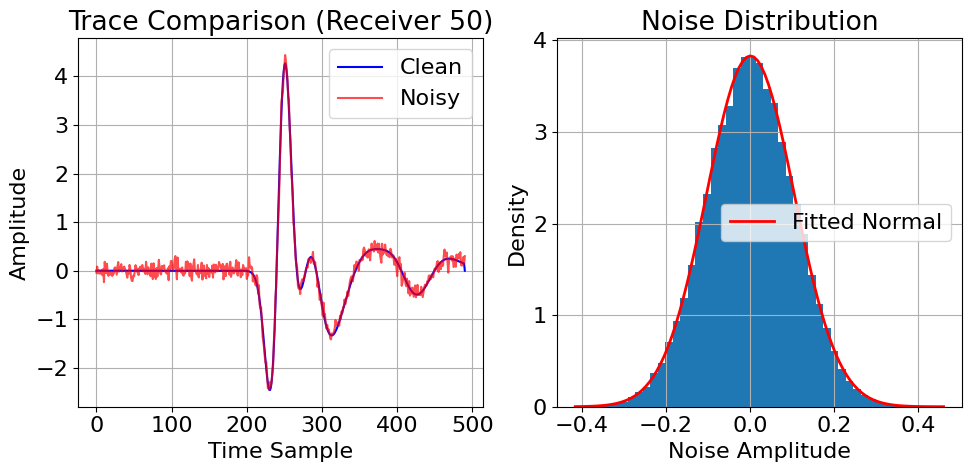

Maximum amplitude in clean data: 5.22e+00
Noise standard deviation: 1.04e-01
Signal-to-Noise Ratio (SNR): 17.36 dB


In [41]:
visualize_noise_effect(solver, model, geometry, source_locations[1],0.02)


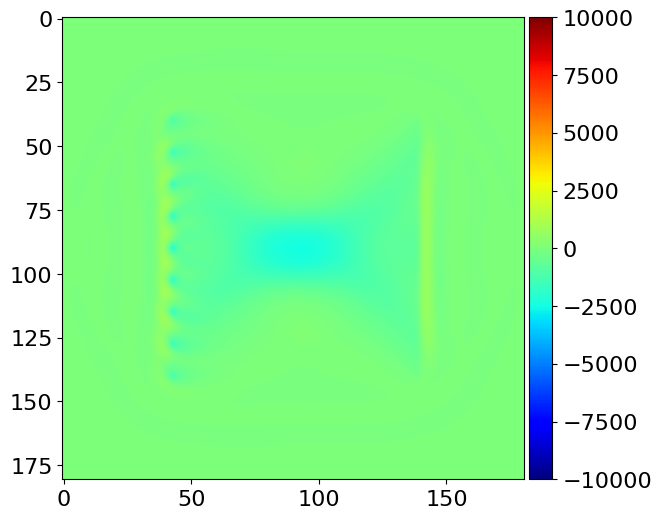

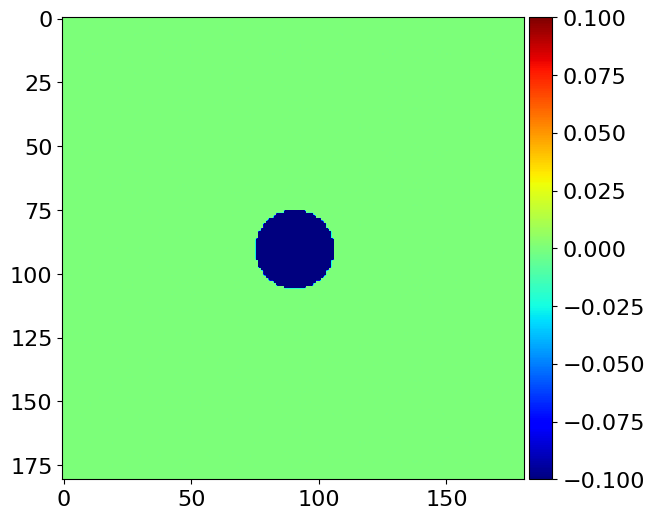

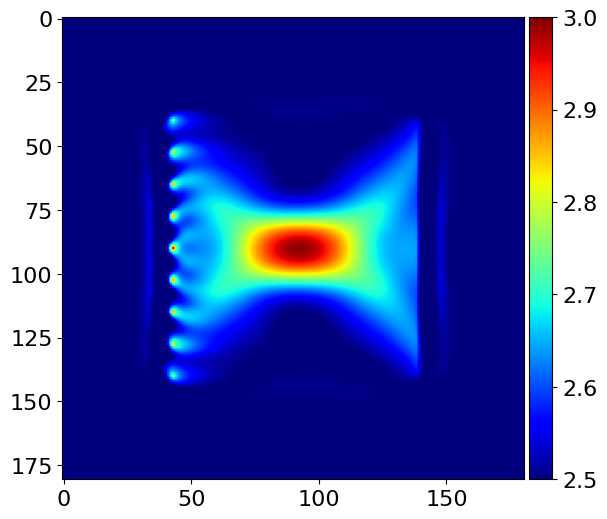

In [42]:
#NBVAL_IGNORE_OUTPUT
from devito import mmax
from examples.seismic import plot_image

# Plot the FWI gradient
plot_image(-update.data, vmin=-1e4, vmax=1e4, cmap="jet")

# Plot the difference between the true and initial model.
# This is not known in practice as only the initial model is provided.
plot_image(model0.vp.data - model.vp.data, vmin=-1e-1, vmax=1e-1, cmap="jet")

# Show what the update does to the model
alpha = .5 / mmax(update)
plot_image(model0.vp.data + alpha*update.data, vmin=2.5, vmax=3.0, cmap="jet")

We see that the gradient and the true perturbation have the same sign, therefore, with an appropriate scaling factor, we will update the model in the correct direction.

In [43]:
from devito import Min, Max
# Define bounding box constraints on the solution.
def update_with_box(vp, alpha, dm, vmin=2.0, vmax=3.5):
    """
    Apply gradient update in-place to vp with box constraint

    Notes:
    ------
    For more advanced algorithm, one will need to gather the non-distributed
    velocity array to apply constrains and such.
    """
    update = vp + alpha * dm
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

In [45]:
#NBVAL_SKIP

from devito import mmax

# Run FWI with gradient descent
history = np.zeros((7, 1))
for i in range(0, 7):
    # Compute the functional value and gradient for the current
    # model estimate
    phi, direction = fwi_gradient(model0.vp,0.01)
    
    # Store the history of the functional values
    history[i] = phi
    
    # Artificial Step length for gradient descent
    # In practice this would be replaced by a Linesearch (Wolfe, ...)
    # that would guarantee functional decrease Phi(m-alpha g) <= epsilon Phi(m)
    # where epsilon is a minimum decrease constant
    alpha = .05 / mmax(direction)
    
    # Update the model estimate and enforce minimum/maximum values
    update_with_box(model0.vp , alpha , direction)
    
    # Log the progress made
    print('Objective value is %f at iteration %d' % (phi, i+1))

Objective value is 39948.480469 at iteration 1
Objective value is 25165.423828 at iteration 2
Objective value is 15035.187500 at iteration 3
Objective value is 8577.208984 at iteration 4
Objective value is 4610.015137 at iteration 5
Objective value is 2272.585693 at iteration 6
Objective value is 1236.556396 at iteration 7


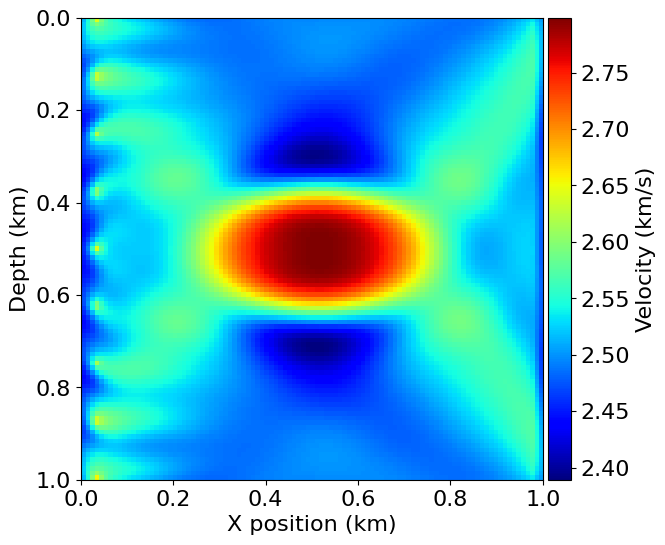

In [47]:
#NBVAL_IGNORE_OUTPUT

# Plot inverted velocity model
plot_velocity(model0)

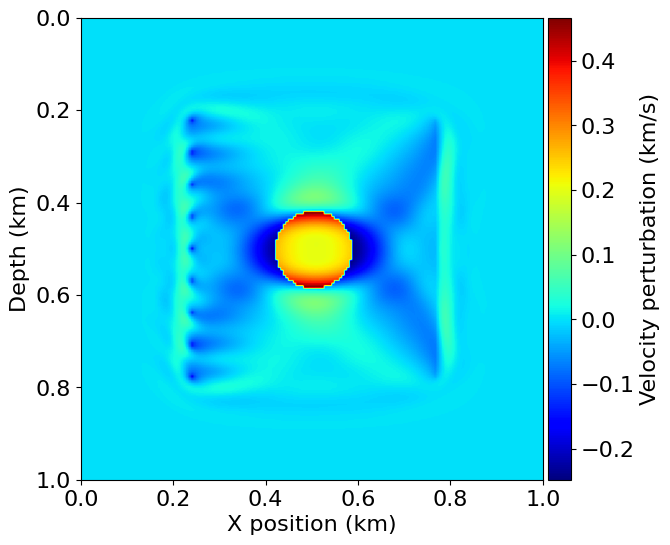

In [48]:
plot_perturbation(model,model0)

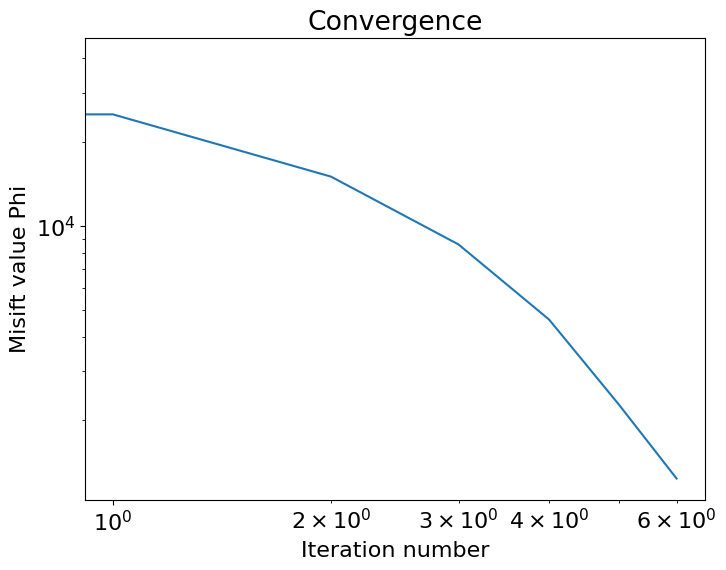

In [49]:
#NBVAL_SKIP
import matplotlib.pyplot as plt

# Plot objective function decrease
plt.figure()
plt.loglog(history)
plt.xlabel('Iteration number')
plt.ylabel('Misift value Phi')
plt.title('Convergence')
plt.show()

## References

[1] _Virieux, J. and Operto, S.: An overview of full-waveform inversion in exploration geophysics, GEOPHYSICS, 74, WCC1–WCC26, doi:10.1190/1.3238367, http://library.seg.org/doi/abs/10.1190/1.3238367, 2009._

[2] _Haber, E., Chung, M., and Herrmann, F. J.: An effective method for parameter estimation with PDE constraints with multiple right hand sides, SIAM Journal on Optimization, 22, http://dx.doi.org/10.1137/11081126X, 2012._

<sup>This notebook is part of the tutorial "Optimised Symbolic Finite Difference Computation with Devito" presented at the Intel® HPC Developer Conference 2017.</sup>